### 要点

手动编环境是一件很耗时间的事情, 所以如果有能力使用别人已经编好的环境, 可以节约我们很多时间. OpenAI gym 就是这样一个模块, 他提供了我们很多优秀的模拟环境. 我们的各种 RL 算法都能使用这些环境. 不过 OpenAI gym 暂时只支持 MacOS 和 Linux 系统. Windows 已经支持, 但是听说还没有全面支持, 大家时不时查看下官网, 可能就有惊喜. 是在等不及更新了, 也行用 tkinter 来手动编写一下环境. 这里有我制作的很好的 tkinter 入门教程, 之前的 maze 环境也是用 tkinter 编出来的. 大家可以仿照这个文件编写就 ok 啦. 或者还可以玩玩更厉害的, 想 OpenAI 一样, 使用 pyglet 模块来编写, 我做了一个从环境开始编写的强化学习实战.

### 安装

在 MacOS 和 Linux 系统下, 安装 gym 很方便, 首先确定你是 python 2.7 或者 python 3.5 版本. 然后在你的 terminal 中复制下面这些. 但是 gym 暂时还不完全支持 Windows, 不过有些虚拟环境已经的到了支持, 想立杆子那个已经支持了. 所以接下来要说的安装方法只有 MacOS 和 Linux 的. Windows 用户的安装方式应该也差不多, 如果 Windows 用户遇到了问题, 欢迎在留言区分享解决的方法.
#python 2.7, 复制下面
$ pip install gym

#python 3.5, 复制下面
$ pip3 install gym

如果没有报错, 恭喜你, 这样你就装好了 gym 的最基本款, 可以开始玩以下游戏啦:
algorithmic
toy_text
classic_control (这个需要 pyglet 模块)
如果在安装中遇到问题. 可能是缺少了一些必要模块, 可以使用下面语句来安装这些模块(安装时间可能有点久):
#MacOS:

$ brew install cmake boost boost-python sdl2 swig wget

#Ubuntu 14.04:

$ apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

如果想要玩 gym 提供的全套游戏, 下面这几句就能满足你:

#python 2.7, 复制下面

$ pip install gym[all]

#python 3.5, 复制下面

$ pip3 install gym[all]

### CartPole 例子

之前我编写的 maze_env 基本上是按照 gym 环境格式写的, 所以你换成 gym 格式会很简单.

接下来我们对应上面的算法, 来实现主循环. 首先 import 所需模块.

In [3]:
"""
This part of code is the DQN brain, which is a brain of the agent.
All decisions are made in here.
Using Tensorflow to build the neural network.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import pandas as pd
import tensorflow as tf


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]
        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]
        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]
        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib
        import matplotlib.pyplot as plt
        %matplotlib inline
        
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


In [4]:
import gym

env = gym.make('CartPole-v0')   # 定义使用 gym 库中的那一个环境
env = env.unwrapped # 不做这个会有很多限制

print(env.action_space) # 查看这个环境中可用的 action 有多少个
print(env.observation_space)    # 查看这个环境中可用的 state 的 observation 有多少个
print(env.observation_space.high)   # 查看 observation 最高取值
print(env.observation_space.low)    # 查看 observation 最低取值

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(2)
Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


C:\Users\OS\Anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


于之前使用 tkinter 定义的环境有点不一样, 我们可以不适用 if __name__ == "__main__" 的方式, 下面是一种类似, 却更简单的写法. 之中我们会用到里面的 reward, 但是 env.step() 说提供的 reward 不一定是最有效率的 reward, 我们大可对这些进行修改, 使 DQN 学得更有效率. 你可以自己对比一下不修改 reward 和 按我这样修改, 他们学习过程的不同.

In [5]:
# 定义使用 DQN 的算法
RL = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=env.observation_space.shape[0],
                  learning_rate=0.01, e_greedy=0.9,
                  replace_target_iter=100, memory_size=2000,
                  e_greedy_increment=0.0008,)

total_steps = 0 # 记录步数

for i_episode in range(50):

    # 获取回合 i_episode 第一个 observation
    observation = env.reset()
    ep_r = 0
    while True:
        env.render()    # 刷新环境

        action = RL.choose_action(observation)  # 选行为

        observation_, reward, done, info = env.step(action) # 获取下一个 state

        x, x_dot, theta, theta_dot = observation_   # 细分开, 为了修改原配的 reward

        # x 是车的水平位移, 所以 r1 是车越偏离中心, 分越少
        # theta 是棒子离垂直的角度, 角度越大, 越不垂直. 所以 r2 是棒越垂直, 分越高

        x, x_dot, theta, theta_dot = observation_
        r1 = (env.x_threshold - abs(x))/env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta))/env.theta_threshold_radians - 0.5
        reward = r1 + r2   # 总 reward 是 r1 和 r2 的结合, 既考虑位置, 也考虑角度, 这样 DQN 学习更有效率

        # 保存这一组记忆
        RL.store_transition(observation, action, reward, observation_)

        if total_steps > 1000:
            RL.learn()  # 学习

        ep_r += reward
        if done:
            print('episode: ', i_episode,
                  'ep_r: ', round(ep_r, 2),
                  ' epsilon: ', round(RL.epsilon, 2))
            break

        observation = observation_
        total_steps += 1
# 最后输出 cost 曲线
RL.plot_cost()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
episode:  0 ep_r:  7.33  epsilon:  0
episode:  1 ep_r:  3.13  epsilon:  0
episode:  2 ep_r:  4.27  epsilon:  0
episode:  3 ep_r:  11.24  epsilon:  0
episode:  4 ep_r:  8.98  epsilon:  0
episode:  5 ep_r:  2.58  epsilon:  0
episode:  6 ep_r:  0.89  epsilon:  0
episode:  7 ep_r:  4.67  epsilon:  0
episode:  8 ep_r:  5.75  epsilon:  0
episode:  9 ep_r:  6.36  epsilon:  0
episode:  10 ep_r:  1.86  epsilon:  0
episode:  11 ep_r:  6.04  epsilon:  0
episode:  12 ep_r:  6.39  epsilon:  0
episode:  13 ep_r:  1.91  epsilon:  0
episode:  14 ep_r:  3.07  epsilon:  0
episode:  15 ep_r:  16.51  epsilon:  0
episode:  16 ep_r:  3.05  epsilon:  0
episode:  17 ep_r:  2.33  epsilon:  0
episode:  18 ep_r:  4.07  epsilon:  0
episode:  19 ep_r:  3.82  epsilon:  0
episode:  20 ep_r:  2.44  epsilon:  0
episode:  21 ep_r:  3.2  epsilon:  0
episode:  22 ep_r:  19.62  epsilon:  0
episode:  23 ep_

<Figure size 640x480 with 1 Axes>

### MountainCar 例子

代码基本和上述代码相同, 就只是在 reward 上动了下手脚.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\OS\Anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)



target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced



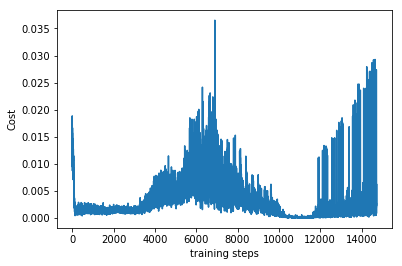

In [4]:
import gym

env = gym.make('MountainCar-v0')
env = env.unwrapped

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

RL = DeepQNetwork(n_actions=3, n_features=2, learning_rate=0.001, e_greedy=0.9,
                  replace_target_iter=300, memory_size=3000,
                  e_greedy_increment=0.0001,)

total_steps = 0


for i_episode in range(10):

    observation = env.reset()
    ep_r = 0
    while True:
        env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        position, velocity = observation_

        # 车开得越高 reward 越大
        reward = abs(position - (-0.5))

        RL.store_transition(observation, action, reward, observation_)

        if total_steps > 1000:
            RL.learn()

        ep_r += reward
        if done:
            get = '| Get' if observation_[0] >= env.unwrapped.goal_position else '| ----'
            print('Epi: ', i_episode,
                  get,
                  '| Ep_r: ', round(ep_r, 4),
                  '| Epsilon: ', round(RL.epsilon, 2))
            break

        observation = observation_
        total_steps += 1

RL.plot_cost()

这两个都只是例子而已, 具体的实施你也可以大动手脚, 比如你的 reward 定义得更好, 你的神经网络结构更好, 使得他们学的更快. 这些都是自己定义的.